In [1]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn


from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os

import numpy as np
device = torch.device('cpu')

In [2]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


In [3]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,
                         conv1_eps_weight,
                         conv1_eps_bias,
                         conv2_eps_weight,
                         conv2_eps_bias,
                         fc1_eps_weight,
                         fc1_eps_bias, 
                         fc2_eps_weight,
                         fc2_eps_bias,
                         add_symbol=False,
                         device=torch.device("cpu")):
        self.device=device
        AR.max_symbol = 200_000
        AM.max_symbol = np.inf
        AR.recycling = 1
        AM.recycling =1 
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)
        print("test1")
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv1,x,x_true,conv1_eps_weight , conv1_eps_bias,device=self.device)
        print('test2')
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print('test3')
        symb_1 = len(x)
       
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv2,x,x_true,conv2_eps_weight,conv2_eps_bias,device=self.device)
        print("test4")
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print("test5")
        print(len(x))
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
        print("test6")
        print(len(x))
        symb_conv2 =len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc1,x,x_true,fc1_eps_weight,fc1_eps_bias,device=self.device)
        print('test7')
        print(len(x))
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print('test8')
        print(len(x))
        symb_fc1 = len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc2,x,x_true,fc2_eps_weight,fc2_eps_bias,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        
        
        return x,x_min,x_max,x_true,symb_1,symb_conv2, symb_fc1
        

Label:5


torch.Size([2, 1, 28, 28])

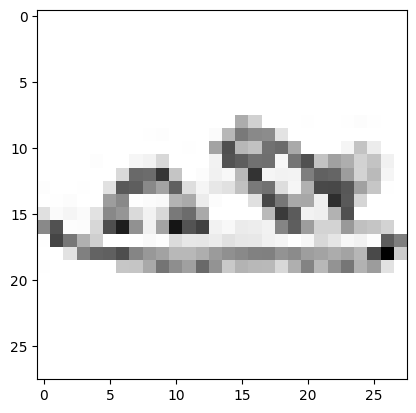

In [4]:

import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[1310]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape
from abstract import abstractTensor as AT

x=AT(img,alpha =torch.tensor([]))
x=x.abstract_tensor()
x.shape

In [ ]:
model = AbstractNN()

In [ ]:
scale = 0.0001
conv1_eps_weight = torch.tensor([])
conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
conv1_eps_weight.values = scale*(1)*torch.ones_like(conv1_eps_weight.indices)
conv1_eps_bias = torch.tensor([])
conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
conv1_eps_bias.values = scale*(1)*torch.ones_like(conv1_eps_bias.indices)


conv2_eps_weight = torch.tensor([])
conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
conv2_eps_weight.values = scale*(1)*torch.ones_like(conv2_eps_weight.indices)
conv2_eps_bias = torch.tensor([])
conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
conv2_eps_bias.values = scale*(1)*torch.ones_like(conv2_eps_bias.indices)

fc1_eps_weight = torch.tensor([])
fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
fc1_eps_weight.values = scale*(1)*torch.ones_like(fc1_eps_weight.indices)
fc1_eps_bias = torch.tensor([])
fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
fc1_eps_bias.values = scale*(1)*torch.ones_like(fc1_eps_bias.indices)


fc2_eps_weight = torch.tensor([])
fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
fc2_eps_weight.values = scale*(1)*torch.ones_like(fc2_eps_weight.indices)
fc2_eps_bias = torch.tensor([])
fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
fc2_eps_bias.values = scale*(1)*torch.ones_like(fc2_eps_bias.indices)

In [ ]:
model = AbstractNN()

In [ ]:
with torch.no_grad():

   result,x_min,x_max,x_true,_,_,_=model.abstract_forward(x,
                                                    conv1_eps_bias=conv1_eps_bias,
                                                    conv1_eps_weight=conv1_eps_weight,
                                                    conv2_eps_weight = conv2_eps_weight,
                                                    conv2_eps_bias = conv2_eps_bias,
                                                    fc1_eps_weight =fc1_eps_weight,
                                                    fc1_eps_bias = fc1_eps_bias, 
                                                    fc2_eps_weight = fc2_eps_weight,
                                                    fc2_eps_bias = fc2_eps_bias,

                                                    
                                                    add_symbol=True)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

In [ ]:
result.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dominance(result,x_min,x_max,x_true):
       y_min       =  np.array(x_min)
       y_max       =  np.array(x_max)
       center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
       y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)



       




       x_scale = np.arange(len(y_min))
       D =np.stack((y_min,y_max),axis=1)

       print(D.shape)
       print(center_Ztp.shape)
       print(y_true.shape)
       # plot:

       fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
       ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
       ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
       ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

       ax.set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
              ylim=(np.min(D), np.max(D)))
       plt.ylabel("Value of the abstract domain")
       plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
       plt.legend()
       plt.show()

In [ ]:
model = AbstractNN()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT

for i in tqdm(range(50)):
    scale = 0.0001
    conv1_eps_weight = torch.tensor([])
    conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
    conv1_eps_weight.values = scale*(1)*torch.ones_like(conv1_eps_weight.indices)
    conv1_eps_bias = torch.tensor([])
    conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
    conv1_eps_bias.values = scale*(1)*torch.ones_like(conv1_eps_bias.indices)


    conv2_eps_weight = torch.tensor([])
    conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
    conv2_eps_weight.values = scale*(1)*torch.ones_like(conv2_eps_weight.indices)
    conv2_eps_bias = torch.tensor([])
    conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
    conv2_eps_bias.values = scale*(1)*torch.ones_like(conv2_eps_bias.indices)

    fc1_eps_weight = torch.tensor([])
    fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
    fc1_eps_weight.values = scale*(1)*torch.ones_like(fc1_eps_weight.indices)
    fc1_eps_bias = torch.tensor([])
    fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
    fc1_eps_bias.values = scale*(1)*torch.ones_like(fc1_eps_bias.indices)


    fc2_eps_weight = torch.tensor([])
    fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
    fc2_eps_weight.values = scale*(1)*torch.ones_like(fc2_eps_weight.indices)
    fc2_eps_bias = torch.tensor([])
    fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
    fc2_eps_bias.values = scale*(1)*torch.ones_like(fc2_eps_bias.indices)
   

    img, label = dataset_train[np.random.randint(0,1000)]

   
   
    

    x=AT(img,alpha =torch.tensor([]))
    x=x.abstract_tensor()
    x.shape

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=False)
    plot_dominance(result,x_min,x_max,x_true)
    print(f"Label = {label}")

    concatenated_tensors = []
    concatenated_bias_tensors =[]
    for j in range(10):
        concat_part = result[1:145, j].view(16, 1, 3, 3)
        concatenated_tensors.append(concat_part)
    concatenated_tensors =torch.stack(concatenated_tensors)
    for j in range(10):
        concat_part_bias = result[145:161, j]
        concatenated_bias_tensors.append(concat_part_bias)
    concatenated_bias_tensors = torch.stack(concatenated_bias_tensors)

    concatenated_tensors_2 = []
    concatenated_bias_tensors_2 =[]
    for j in range(10):
        concat_part = result[len_symb:len_symb+4608, j].view(32, 16, 3, 3)
        concatenated_tensors_2.append(concat_part)
    concatenated_tensors_2 =torch.stack(concatenated_tensors_2)
    for j in range(10):
        concat_part_bias = result[len_symb+4608:len_symb+4640, j]
        concatenated_bias_tensors_2.append(concat_part_bias)
    concatenated_bias_tensors_2 = torch.stack(concatenated_bias_tensors_2)

    concatenated_tensors_fc1 = []
    concatenated_bias_tensors_fc1 =[]
    for j in range(10):
        concat_part = result[len_symb_c2:len_symb_c2+294912, j].view(64,4608)
        concatenated_tensors_fc1.append(concat_part)
    concatenated_tensors_fc1 =torch.stack(concatenated_tensors_fc1)
    for j in range(10):
        concat_part_bias = result[len_symb_c2+294912:len_symb_c2+294976, j]
        concatenated_bias_tensors_fc1.append(concat_part_bias)
    concatenated_bias_tensors_fc1= torch.stack(concatenated_bias_tensors_fc1)

    concatenated_tensors_fc2 = []
    concatenated_bias_tensors_fc2 =[]
    for j in range(10):
        concat_part = result[len_symb_fc1:len_symb_fc1+640, j].view(10,64)
        concatenated_tensors_fc2.append(concat_part)
    concatenated_tensors_fc2 =torch.stack(concatenated_tensors_fc2)
    for j in range(10):
        concat_part_bias = result[len_symb_fc1+640:len_symb_fc1+650, j]
        concatenated_bias_tensors_fc2.append(concat_part_bias)
    concatenated_bias_tensors_fc2= torch.stack(concatenated_bias_tensors_fc2)
    k_min = 1
    k_plus = 10

   
    

    model.conv1.weight.data =model.conv1.weight.data+k_plus*(concatenated_tensors[label]-k_min*(torch.sum(concatenated_tensors[:label],dim =0)+torch.sum(concatenated_tensors[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv1.bias.data = model.conv1.bias.data + k_plus*(concatenated_bias_tensors[label]-k_min*(torch.sum(concatenated_bias_tensors[:label],dim = 0)+torch.sum(concatenated_bias_tensors[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.conv2.weight.data =model.conv2.weight.data+k_plus*(concatenated_tensors_2[label]-k_min*(torch.sum(concatenated_tensors_2[:label],dim =0)+torch.sum(concatenated_tensors_2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv2.bias.data = model.conv2.bias.data + k_plus*(concatenated_bias_tensors_2[label]-k_min*(torch.sum(concatenated_bias_tensors_2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_2[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(concatenated_tensors_fc1[label]-k_min*(torch.sum(concatenated_tensors_fc1[:label],dim =0)+torch.sum(concatenated_tensors_fc1[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(concatenated_bias_tensors_fc1[label]-k_min*(torch.sum(concatenated_bias_tensors_fc1[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc1[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(concatenated_tensors_fc2[label]-k_min*(torch.sum(concatenated_tensors_fc2[:label],dim =0)+torch.sum(concatenated_tensors_fc2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(concatenated_bias_tensors_fc2[label]-k_min*(torch.sum(concatenated_bias_tensors_fc2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc2[label+1:],dim = 0)))#/torch.no


In [ ]:
model.fc2[1].weight.data.shape

In [ ]:
conv1_eps_bias.values

In [ ]:
list

In [ ]:
conv1_eps_weight.values
model.conv1.weight.data

In [ ]:
test = np.arange(0,10,1)
test[1:5]
test[5:10]

In [ ]:
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)

In [ ]:
eval.evaluate_model(dataset_test)

In [ ]:
torch.save(model.state_dict(), f'abstractLearn.pth')

In [ ]:
model.load_state_dict(torch.load('dataset/FMNIST.pth'))